In [1]:
### GENERIC LIBRARIES #####

import matplotlib.pyplot as plt
import numpy as np
import emcee

#### DATA TREATMENT ####

import pandas as pd

######## FIT LIBRARIES ####

import lmfit
from lmfit import Parameters, Parameter


###### INTERPOLATION LIBRARIES #####

from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, brentq
from scipy.interpolate import UnivariateSpline


from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy.stats import chi2_contingency


import scipy.integrate as integrate
import scipy.special as special




#########CORNER ##########


import corner
import pygtc



###############################

from lmfit.model import save_modelresult
from lmfit.model import load_modelresult

#other useful features
from inspect import signature
from numpy import log10
from numpy import log
from numpy import pi
from scipy.optimize import minimize
#from IPython.display import display, Math
plt.rcParams['text.usetex'] = True
from scipy.special import hyp2f1
from numpy import exp
import warnings

In [2]:
#Useful constants in SI

hbar = 1.054571817e-34 #reduced Planck constant
e = 1.60217662e-19 #elementary charge
c0 = 2.99792458e8 #speed of light in vacuum
G = 6.67430e-11 #Gravitational constant
#Solar mass
sm = 1.98847e30
#Parsec
pc = 3.0856775814913673e16


#length scale of natural units

evm = hbar*c0/e
#time scale of natural units
evs = hbar/e
#mass scale of natural units
evkg = e/c0**2



#Hubble constant (km/s/Mpc)
H = 67.8

#Reduced Hubble constant
h = H/100

#H = 70

om = 0.284 # matter density parameter

pcrit = 3*(H*1000/(1e6*pc))**2/(8*np.pi*G) #cosmological matter density

pom = om*pcrit #cosmological matter density

#Relevant quantities in natural units (hbar = 1, c0 = 1)

#typical axion mass (eV)
ma=1e-22

#gravitational constant
evG = G*e**2/(c0**5*hbar)
#Planck mass
evMpl = 1/np.sqrt(evG)
#Hubble constant
evH = H*1000/(pc*1e6)*hbar/e
#Cosmological critical density
rc = 3*evH**2/(8*np.pi*evG)
#NFW characteristic radius
#evrs = rs/evm
#Solar mass
evsm = sm/evkg
#Parsec
evpc=pc/evm

evpom = pom*(evm**3)/evkg #cosmological matter density

#Some general formatting settings for plotting
plt.style.use('default')
#[Note: if you encounter an error, ensure the Latex package is installed in your computer
#(or erase the line below)]
#pl.rc('text', usetex=True)
plt.rc('font', family='serif')
size=17
width=1
dash=(10,2)
i10=-1

#Radius [kpc], density [kg/m^3] and rotation curve [km/s] solution of SP equation for lambda = ma = 1
# xvals = np.loadtxt('SP_SOL/xvalues_kpc.txt')
# pvals = np.loadtxt('SP_SOL/pvalues_kgm3.txt')
# vvals = np.loadtxt('SP_SOL/vvalues_kms.txt')


from scipy.interpolate import interp1d

#Interpolated densities and velocities for the above solutions

# intvels = interp1d(xvals, vvals, kind='linear')

# intps = interp1d(xvals, pvals, kind='linear')

In [3]:
#functions required for building the prior and model

fac = 102 #critical density factor
def d(c):
    return (fac/3)*c**3/(log(1+c)-c/(1+c))

#NFW-only DM rotation curve
def vNFW(x, c, vir):
    
    #Virial speed (m/s)
    vir = 1000*vir
    
    #Virial mass (kg)
    MV = np.sqrt(vir**6 / ((4/3)*pi*fac*pcrit*G**3))
    
    #NFW radius
    rs = (MV/(fac*pcrit*(4*np.pi/3)*c**3))**(1/3)/(1000*pc)
    
    #NFW density scale
    p0 = pcrit*d(c)
    
    #NFW rotation curve 
    def vnfw0(r):
       
        return np.sqrt(G*4*np.pi*p0*(rs*1000*pc)**3*(log((rs + r)/(rs)) + rs/(rs + r)\
                                                           - 1)/(1000*pc*r))/1000
    
    return vnfw0(x)

#Full rotation curve predicted
def vmodel(c, vir, lmd, lmb, R, Vgas, Vdisk, Vbul):
    
    return np.sqrt(vNFW(R, c, vir)**2 + abs(Vgas)*Vgas + lmd*abs(Vdisk)*Vdisk + lmb*abs(Vbul)*Vbul)
    
#stellar mass
def mstar(lmd, lmb, ltot, lbul):
    return lmd*(ltot - lbul) + lmb*lbul

#m-log10(c) relation
def lmcrel(mv):
    return 1.025 - 0.097*log10(mv/(sm*1e12/h))


#log-prior function (NGC 4013 galaxy)


def lprior(c, vir, lmd, lmb, R, Vobs, Vgas, Vdisk, Vbul, \
           ltot = 79.094*1e9*sm, lbul = 15.3853*1e9*sm, mh1 = 2.967*1e9*sm, vf = 172.9):
            
        
            if 1e-6 <= c <= 100 and 1e-6 <= lmd <= 100 and 1e-6 <= lmb <= 100 and 1e-6 <= vir <= 500:
                    mv = np.sqrt((vir*1000)**6 / ((4/3)*pi*fac*pcrit*G**3))

                    mud = log10(0.5)
                    sd = 0.1

                    mub = log10(0.7)
                    sb = 0.1

                    mbtot = mh1 + mstar(lmd, lmb, ltot, lbul)

                    vmax = max(vmodel(c, vir, lmd, lmb, R, Vgas, Vdisk, Vbul))

                    if 0 <= mbtot/mv <= 0.2 and 2**(-0.5) <= vmax/vf <= 2**0.5:

                        return -0.5 *( (log10(lmd) - mud)**2 / sd**2 + \
                    (log10(lmb) - mub)**2 / sb**2)-0.5*(log10(c) - lmcrel(mv))**2 / (0.11)**2

            return -np.inf
               
        

In [4]:
#optimizer that looks for a finite-value log-probability optimum
#It works by perturbing the initial guess with sigma normal
#fluctuations (sig*100 is the percentage relative to the mean), 
#it then uses the scipy optimizer to find finite local 
#maxima of the probability and selects the best of those to get
# an estimate of the global one


def optimizer(name, lpost, init, ndim, stps, sig, period = 100):
    
        params = []
        
        nlprobs = []
    
        init0 = init
        
        df = np.loadtxt(str(name + '_rotmod.dat'), unpack = True)

        R  = df[0]
        Vobs  = df[1]
        errV = df[2]
        Vgas = df[3]
        Vdisk = df[4]
        Vbul = df[5]
        nll = lambda *args: - lpost(*args)
        

        for i in range(stps):
            
            if i%period == 0:
                
                init = init0

            rand = np.random.randn(ndim)

            for j in range(ndim):
                    rand[j] *= sig*init[j]


            init = init + rand

            soln = minimize(nll, init, args=(R, Vobs, Vgas, Vdisk, Vbul, errV))

            init = soln.x
            
            nlpr = nll(init, R, Vobs, Vgas, Vdisk, Vbul, errV);
            
            if np.isfinite(nlpr): 
                
                      params.append(init)
                      nlprobs.append(nlpr)
  
       
        if len(nlprobs) == 0:
            print("No viable log-probability optimisation found:")
            print( " ")
            print(init)
            return init
        
        mlprob = 1e6
        
        for j in range(len(nlprobs)):
            if nlprobs[j] < mlprob:
                mlprob = nlprobs[j]
                init = params[j]
                
        print("Global log-probability optimum found:")
        print( " ")
        print(init)
        return init

In [5]:
size = 20

plt.rcParams['text.usetex'] = True

#General emcee sampler for a given SPARC galaxy, model, prior and initial guess of parameters
def MCMC(name, vmodel, lprior, init, ndim = 4, \
         labels = [r'$c$', r'$V_{vir}$ [km/s]', r'$\Upsilon_{*, disk}$', r'$\Upsilon_{*, bulge}$'],\
         modelname = "NFW", nwalkers = 48, steps = 20000, burn = 5000, opstps = 1000, sig = 0.1):
    
        #log-likelihood function
        def llhood(theta, R, Vobs, Vgas, Vdisk, Vbul, errV):
            Vmodel = vmodel(*theta, R, Vgas, Vdisk, Vbul);
            sigma2 = errV**2
            return -0.5*np.sum((Vobs - Vmodel)**2 / sigma2)
        

        #log-posterior function
        def lpost(theta, R, Vobs, Vgas, Vdisk, Vbul, errV):
            lp = lprior(*theta, R, Vobs, Vgas, Vdisk, Vbul);
            
            #discards parameters not satisfying the log-prior conditions
            if not np.isfinite(lp): 
                return -np.inf
            
            llh = llhood(theta, R, Vobs, Vgas, Vdisk, Vbul, errV);
            
            #discards mathematically unsound parameters (those yielding square roots of negative numbers etc.)
            if np.any(np.isnan(lp + llh)) == True: 
                return -np.inf
            
            return lp + llh
                      
        df = np.loadtxt(str(name + '_rotmod.dat'), unpack = True)
        
        R  = df[0]
        Vobs  = df[1]
        errV = df[2]
        Vgas = df[3]
        Vdisk = df[4]
        Vbul = df[5]
        #SBdisk = df[6]
        #SBbul = df[7]
        
        rand = np.random.randn(nwalkers, ndim)
        
        #This avoids error messages when the parameters yield mathematically unsound results (square roots of 
        #negative numbers etc.), these will be discarded from the parameter space, but are computed so #
        #that they can be evaluated
        with warnings.catch_warnings(): 
            warnings.simplefilter('ignore')
            # "refined" initial guess (in case the initial one has divergent log-posterior probability or is 
            #sub-optimal with respect to the log-posterior probability)
            print( " ")
            print("Result for maximum log-posterior estimate:")
            print( " ")
            init = optimizer(name, lpost, init, ndim, opstps, sig)

            for val in rand:
                for i in range(ndim):
                    val[i] *= sig*init[i]

            pos = init + rand;    


            sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost,\
                                            args = (R, Vobs, Vgas, Vdisk, Vbul, errV));


            sampler.run_mcmc(pos, burn + steps, progress=True);

            tau = sampler.get_autocorr_time()
            print( " ")
            print('Autocorrelation time = ', tau)
            print( " ")
            print("Mean acceptance fraction = ", np.mean(sampler.acceptance_fraction))
            print( " ")
            flat_samples = sampler.get_chain(discard=burn, flat=True)

            low = []

            high = []

            med = []

            maxr = []

            minr = []

            print( " ")
            print("Medians within 65% of the sample:")
            print( " ")
            for i in range(ndim):
                mcmc = np.percentile(flat_samples[:, i], [16, 50, 84, 0.1, 99.9])
                q = np.diff(mcmc)
                low.append(mcmc[1] - q[0])
                high.append(mcmc[1] + q[1])
                med.append(mcmc[1])
                minr.append(mcmc[3])
                maxr.append(mcmc[4])
                print( " ")
                print(labels[i]," ", mcmc[1], " ", q[0], " ", q[1])
                print( " ")
           
            
            #The second iteration should be more reliable as it is done about the median value
        #         print("Result for maximum log-posterior estimate (second iteration):")
        #         print( " ")
        #         init = optimizer(name, lpost, med, ndim, opstps, sig)


            #corner plots
            fig = corner.corner(flat_samples, labels=labels, truths=init, fontsize = size,\
           quantiles = (0.16, 0.5, 0.84), \
           show_titles=True, title_fmt='g', use_math_text=True);

            namec = str(name + "_" + modelname + "_corner.pdf")
            plt.savefig(namec)




            n = len(Vobs)    


            low = np.array(low)
            high = np.array(high)
            med = np.array(med)
            maxr = np.array(maxr)
            minr = np.array(minr)
            print( " ")
            print("99.9 percentile values = ", maxr)
            print( " ")
            print("0.1 percentile values = ", minr)

            #Chi-square function
            def chi2(theta, R, Vobs, Vgas, Vdisk, Vbul, errV):

                Vmodel = vmodel(*theta, R, Vgas, Vdisk, Vbul)
                sigma2 = errV**2
                return np.sum((Vobs - Vmodel)**2 / sigma2)

            def rllhood(theta, R, Vobs, Vgas, Vdisk, Vbul, errV):

                count = 0

                for i in range(len(theta)):
                    if minr[i]<= theta[i] <= maxr[i]:
                        count += 1
                if count == len(theta):
                    return llhood(theta, R, Vobs, Vgas, Vdisk, Vbul, errV)

                else:
                    return -np.inf 

            print( " ")
            print("Result for MLE:")
            init2 = optimizer(name, rllhood, med, ndim, opstps, sig)
            print( " ")
            print("BIC (up to a constant) at MLE = ",\
                  chi2(init2, R, Vobs, Vgas, Vdisk, Vbul, errV) + ndim*log(n))
            print( " ")
            print("Reduced chi-square of MLE = ",\
                  chi2(init2, R, Vobs, Vgas, Vdisk, Vbul, errV)/(n - ndim ))
            print( " ")
            print("Reduced chi-square of 0.1 percentile = ",\
                  chi2(minr, R, Vobs, Vgas, Vdisk, Vbul, errV)/(n - ndim ))
            print( " ")
            print("Reduced chi-square of 16 percentile = ",\
                  chi2(low, R, Vobs, Vgas, Vdisk, Vbul, errV)/(n - ndim ))
            print( " ")
            print("Reduced chi-square of 50 percentile (median) = ",\
                  chi2(med, R, Vobs, Vgas, Vdisk, Vbul, errV)/(n - ndim ))
            print( " ")
            print("Reduced chi-square of 84 percentile = ",\
                  chi2(high, R, Vobs, Vgas, Vdisk, Vbul, errV)/(n - ndim ))
            print( " ")

            print("Reduced chi-square of 99.9 percentile = ",\
                  chi2(maxr, R, Vobs, Vgas, Vdisk, Vbul, errV)/(n - ndim ))
            print( " ")

            #rotation curves
            fig, ax = plt.subplots(figsize=(12,10))


            ax.errorbar(R, Vobs, errV, fmt='o', capsize=4, capthick=1.0, color='black',label=r'$V_{obs}$',\
                        marker="o",markersize=10.5,linewidth=0.5,fillstyle='none')

            RX = np.linspace(min(R), max(R), 1000)

            VMODEL = vmodel(*med, R, Vgas, Vdisk, Vbul)

            plt.fill_between(R, vmodel(*low, R, Vgas, Vdisk, Vbul), vmodel(*high, R, Vgas, Vdisk, Vbul),\
                             color='y', alpha=0.2, zorder=0)

            lmd, lmb = init[-2], init[-1]


            VDM = np.sqrt(VMODEL**2 - (abs(Vgas)*Vgas + lmd*abs(Vdisk)*Vdisk + lmb*abs(Vbul)*Vbul))

            ax.plot(R, VMODEL, label=str(modelname + " + baryons"),linewidth=2.5, color = "y")

            ax.plot(R, VDM ,label=str(modelname + " only"),linewidth=2.5)

            ax.plot(R, Vgas ,  label=r'$V_{gas}$',linewidth=2.5)
            ax.plot(R, np.sqrt(lmb)*Vbul ,  label=r'$V_{bulge}$',linewidth=2.5)
            ax.plot(R, np.sqrt(lmd)*Vdisk ,  label=r'$V_{disk}$',linewidth=2.5)
            ax.legend(fontsize = size)
            plt.ylabel(r'$V_{tot}$ $[$ km $/$ s $]$ ', fontsize = size)
            plt.xlabel(r'Radius $[$ kpc $]$ ', fontsize = size)
            plt.xticks(fontsize = size)
            plt.yticks(fontsize = size)
            plt.title(name, fontsize=size)
            namef = str(name + "_" + modelname + "_rot_curve.pdf")
            plt.savefig(namef)




 
Result for maximum log-posterior estimate:
 


  0%|          | 36/25000 [00:00<02:21, 176.44it/s]

Global log-probability optimum found:
 
[  5.76031091 175.31586215   0.52200351   0.79168552]


100%|██████████| 25000/25000 [02:19<00:00, 178.92it/s]


 
Autocorrelation time =  [194.09200227 216.55786146  87.83740881  66.60889868]
 
Mean acceptance fraction =  0.48193833333333336
 
 
Medians within 65% of the sample:
 
 
$c$   5.698662128010961   1.0383622212708943   1.1918092354851462
 
 
$V_{vir}$ [km/s]   176.41658355244456   19.276055896898526   25.97194433213687
 
 
$\Upsilon_{*, disk}$   0.5153569237078501   0.04315920364652187   0.03959060098561895
 
 
$\Upsilon_{*, bulge}$   0.8185978196203353   0.15772179048072177   0.18416181034642565
 
 
99.9 percentile values =  [ 10.22337106 300.86429674   0.62686035   1.47107109]
 
0.1 percentile values =  [  2.82938642 129.7979592    0.36996038   0.4117765 ]
 
Result for MLE:
Global log-probability optimum found:
 
[  2.82939733 295.72232029   0.48036378   1.25132457]
 
BIC (up to a constant) at MLE =  37.471576417764965
 
Reduced chi-square of MLE =  0.7230468957481413
 
Reduced chi-square of 0.1 percentile =  116.4425572025323
 
Reduced chi-square of 16 percentile =  17.1738291370565

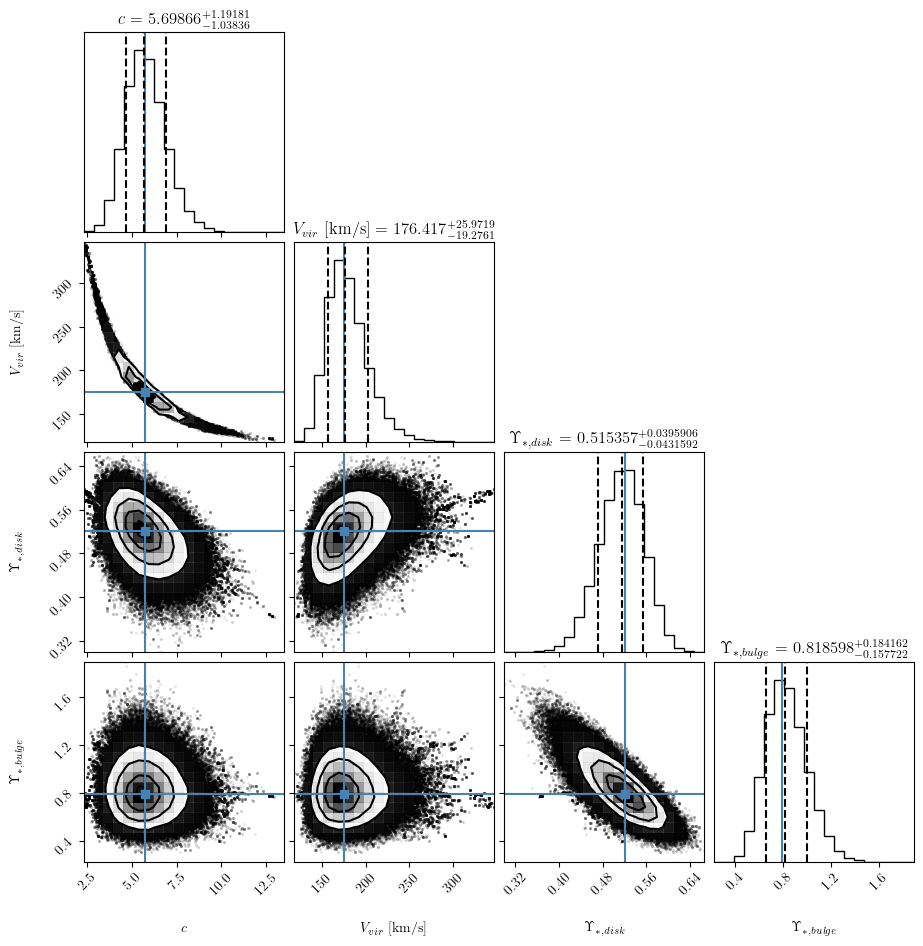

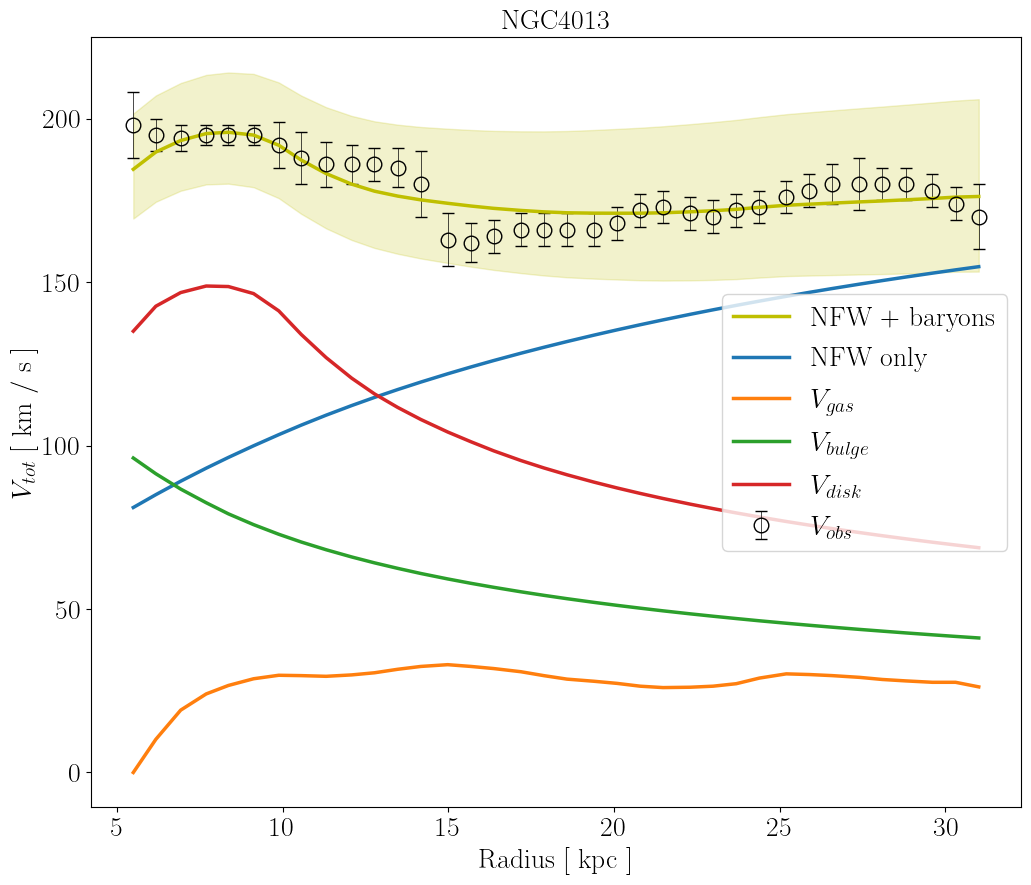

In [6]:
MCMC("NGC4013", vmodel, lprior, np.array([20, 100, 1, 1]))

In [7]:
#DC14 model


def vdc14(c, vir, lmd, lmb, R, Vgas, Vdisk, Vbul,\
ltot = 79.094*1e9*sm, lbul = 15.3853*1e9*sm, mh1 = 2.967*1e9*sm, vf = 172.9):
    
    #Virial speed (m/s)
    vir = 1000*vir;
    
    #Virial mass (kg)
    mv = np.sqrt((vir)**6 / ((4/3)*pi*fac*pcrit*G**3));
    
    #Stellar mass
    mst = mstar(lmd, lmb, ltot, lbul);
    
    X = log10(mst/mv)
    
    alpha = 2.94 - log10((10**(X + 2.33))**(-1.08) + (10**(X + 2.33))**2.29);
    beta = 4.23 + 1.34*X + 0.26*X**2;
    gamma = -0.06 + log10((10**(X + 2.56))**(-0.68) + 10**(X + 2.56));
    
    #Virial radius
    rv = G*mv/vir**2;
    
    #Scale radius
    rs = (G*mv)/(c*vir**2) * ((2 - gamma)/(beta - 2))**(-1/alpha);
    
    #Scale density
    rhos = (1/3) * (3 - gamma) * (rv/rs)**gamma * fac * pcrit / hyp2f1(
    (3 - gamma)/alpha, (beta - gamma)/alpha, 
    (3 + alpha - gamma)/alpha, -(rv/rs)**alpha);

    r = R*1000*pc;
    
    #Square of DM halo rotation curve
    VDM2 = -4*pi*G*r**2 * rhos*(r/rs)**(-gamma) * hyp2f1(
    (3 - gamma)/alpha, (beta - gamma)/alpha, 
    (3 + alpha - gamma)/alpha, -(r/rs)**alpha)/(gamma - 3);
    
    
    return np.sqrt(VDM2/1e6 + abs(Vgas)*Vgas + lmd*abs(Vdisk)*Vdisk + lmb*abs(Vbul)*Vbul)

In [8]:
#DC14 prior

#log-prior function (NGC 4013 galaxy)


def lprior14(c, vir, lmd, lmb, R, Vobs, Vgas, Vdisk, Vbul, \
           ltot = 79.094*1e9*sm, lbul = 15.3853*1e9*sm, mh1 = 2.967*1e9*sm, vf = 172.9):
    
        
            if 1e-6 <= c <= 100 and 1e-6 <= lmd <= 100 and 1e-6 <= lmb <= 100 and 1e-6 <= vir <= 500:
                
                    mv = np.sqrt((vir*1000)**6 / ((4/3)*pi*fac*pcrit*G**3));

                    mud = log10(0.5)
                    sd = 0.1

                    mub = log10(0.7)
                    sb = 0.1
                    
                    mst = mstar(lmd, lmb, ltot, lbul);

                    mbtot = mh1 + mst;

                    vmax = max(vdc14(c, vir, lmd, lmb, R, Vgas, Vdisk, Vbul));

                    if 0 <= mbtot/mv <= 0.2 and 2**(-0.5) <= vmax/vf <= 2**0.5:
                        
                        X = mst/mv;
                        lcrel = lmcrel(mv);


                        return -0.5 *( (log10(lmd) - mud)**2 / sd**2 + \
                    (log10(lmb) - mub)**2 / sb**2)-0.5*(log10(c) - lcrel)**2 / (0.11)**2

            return -np.inf


 
Result for maximum log-posterior estimate:
 


  0%|          | 28/25000 [00:00<03:12, 129.85it/s]

Global log-probability optimum found:
 
[  6.6155729  183.48477466   0.59371728   0.81500454]


100%|██████████| 25000/25000 [03:25<00:00, 121.42it/s]


 
Autocorrelation time =  [83.85722804 77.95607001 62.16778873 53.27206211]
 
Mean acceptance fraction =  0.5613358333333333
 
 
Medians within 65% of the sample:
 
 
$c$   6.641230552014572   0.1895481149077689   0.28619707876134637
 
 
$V_{vir}$ [km/s]   183.94251687891372   14.720268741075444   16.541258280401536
 
 
$\Upsilon_{*, disk}$   0.5855789897240138   0.050405779101691195   0.04594413578931722
 
 
$\Upsilon_{*, bulge}$   0.8433259536806734   0.1628888157817986   0.19522548647726468
 
 
99.9 percentile values =  [  8.59486981 246.50440688   0.71557468   1.54322068]
 
0.1 percentile values =  [  6.11129826 143.87208347   0.41839274   0.42132582]
 
Result for MLE:
Global log-probability optimum found:
 
[  6.48069877 185.65075373   0.50689986   1.27480201]
 
BIC (up to a constant) at MLE =  37.697461942179416
 
Reduced chi-square of MLE =  0.7301058183860931
 
Reduced chi-square of 0.1 percentile =  32.8290703826749
 
Reduced chi-square of 16 percentile =  3.7639504173663063
 

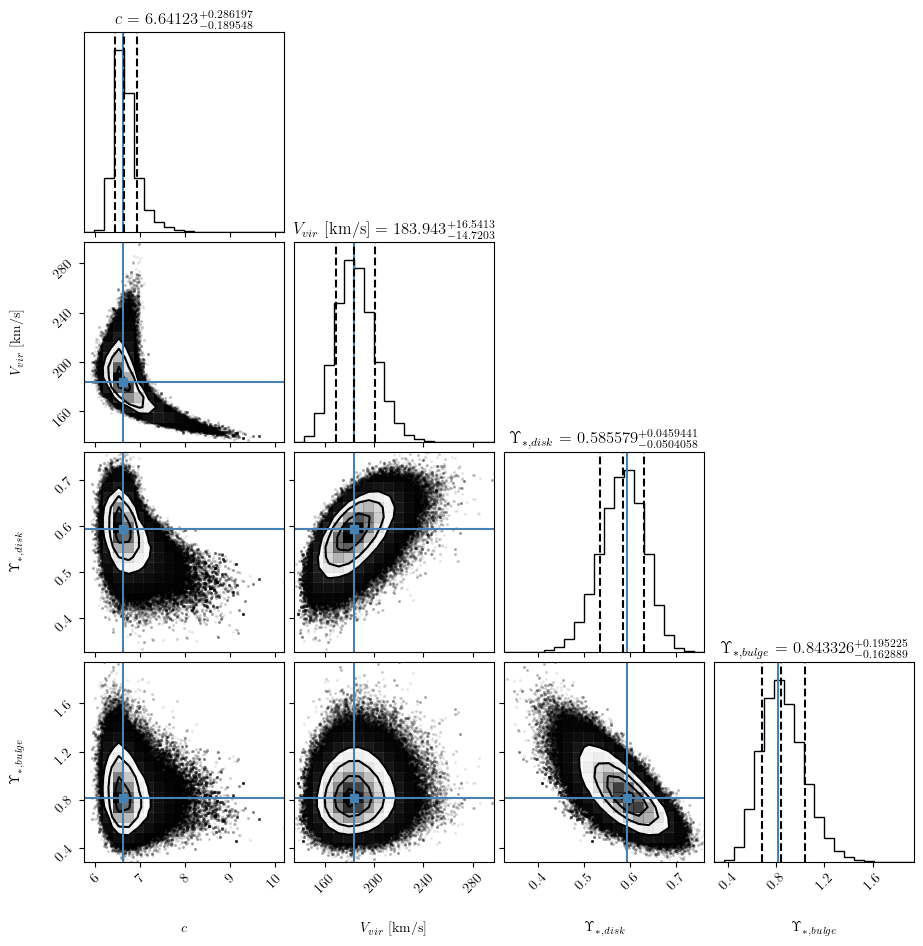

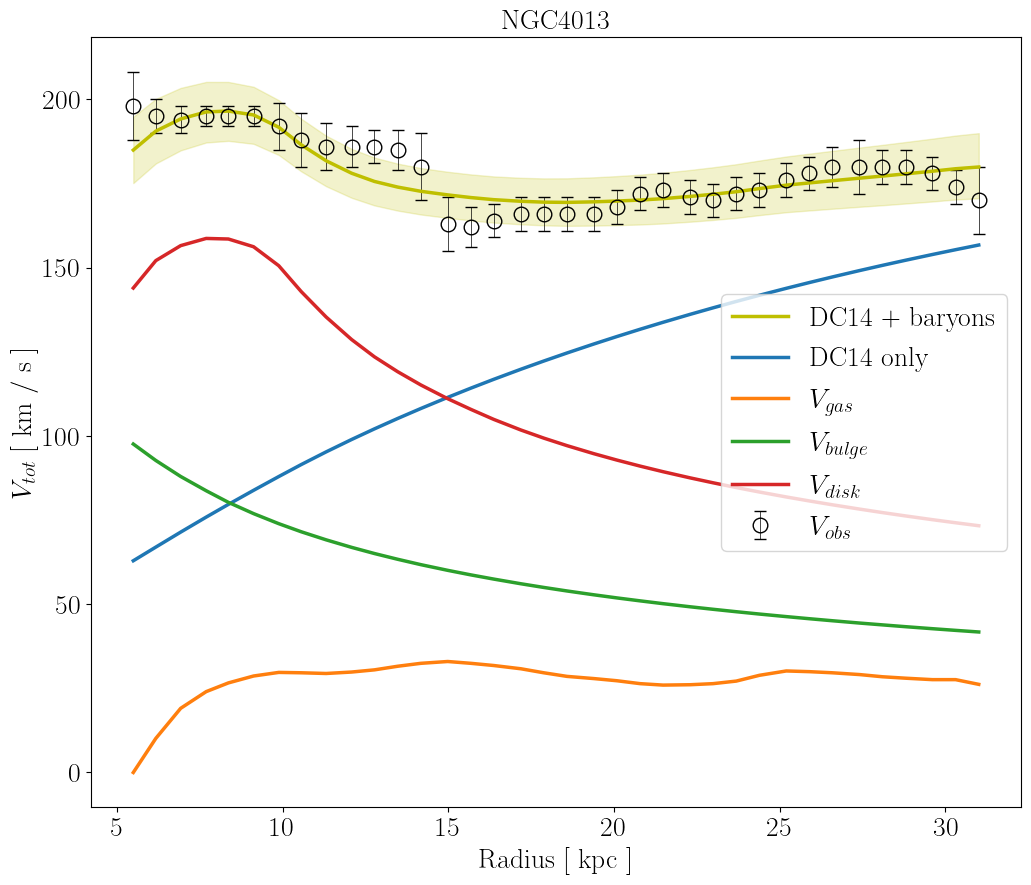

In [9]:
MCMC("NGC4013", vdc14, lprior14, np.array([20, 100, 1, 1]), ndim = 4, \
         labels = [r'$c$', r'$V_{vir}$ [km/s]', r'$\Upsilon_{*, disk}$', r'$\Upsilon_{*, bulge}$'],\
         modelname = "DC14", nwalkers = 48, steps = 20000, burn = 5000, opstps = 1000, sig = 0.1)